# Setup

```
pip install git+https://github.com/scverse/spatialdata.git@main
pip install git+https://github.com/scverse/spatialdata-io.git@main
```

This is the stuff you have to edit; the rest of the sections can run as-is after you've set the needed parameters.

---

`coord_suffix` must align with 
* the sub-directory (corresponds to region, e.g., "mucosa") under the `dir_coord` directory where the Xenium Explorer-exported selection files are stored, and
* the suffixes of the coordinate selection files (see file naming conventions below).
  
The `AnnData` objects created will have this suffix as well (e.g., `Uninflamed-50452A_mucosa.h5ad`).

---

Selection files should be named by this convention:
`<library_id>_<coord_suffix>.csv`.

For example, if `dir_coord` is `.../coordinates/mucosa`, the mucosa selection file for sample 50452A should be under `.../coordinates/mucosa/50452A_mucosa.csv`. 

More specifically, if the coordinates directory is under `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates`, and the selection region is "mucosa,"`dir_coord` should be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa`, and the full file path for this sample would be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa/50452A_mucosa.csv`.

---

**As with any other file naming schema, suffixes/directory names should not any special characters other than underscores (`_`) (no periods, dashes, spaces, etc.).**

N.B. In the above explanation, `library_id` refers to library/original sample ID without condition (e.g., "50452A", not "Uninflamed-50452A" like in other places). Remember that `coord_suffix` should also be the name of the parent directory of the coordinate file. I include this information in both the directory and file name to prevent mix-ups should files be moved or placed in the wrong folder.

Loading the metadata allows us to find the object IDs (e.g., for TUQ97N, object IDs are in the format <condition (Inflamed/Uninflamed/Stricture)><block_id>) corresponding to the sample IDs.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import traceback
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapely.validation
from shapely.geometry import box
import anndata
import scanpy as sc
# import spatialdata_plot
import numpy as np
import pandas as pd
import corescpy as cr

# Main
write_object = True  # change to True when you're ready to save objects
overwrite = False  # overwrite if already exists?
regions = ["mucosa", "serosa", "myenteric_plexus", "submucosa",
           "smc_circular", "smc_longitudinal"]
col_leiden = "leiden_res1pt5_dist0_npc30"
col_ann = "Bucket"
cells_as_circles = True
allow_make_valid = True  # allow shapely package to correct invalid geometries

# Process Options
panel = "TUQ97N"  # Xenium panel ID
constants_dict = cr.get_panel_constants(panel_id=panel)
libs = [  # sample IDs from patients for whom we have all conditions
    "50452A", "50452B", "50452C",  # old segmentation
    "50006A", "50006B", "50006C",  # rest are new segmentation
    "50217A", "50217B", "50217C",
    "50336B", "50336C", "50336A",
    "50403A2", "50403B", "50403C1"
]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
# libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
#         "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
# libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area

# Files & Directories
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with data
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_"
          f"{panel}.csv")  # metadata file path (for now; will soon be on NFS)
dir_writeable = os.path.join(
    dir_entry, f"elizabeth/data/shared-xenium-library")  # where objects are
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel}/nebraska")  # object output directory

#  Your Folders
out_new = os.path.join(
    dir_entry,
    f"{os.getlogin()}/data/shared-xenium-library/outputs/{panel}/nebraska")

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
os.makedirs(out_dir, exist_ok=True)  # make output directory if needed
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs)
metadata[col_subject]

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Sample
Uninflamed-50452A     50452
Inflamed-50452B       50452
Stricture-50452C      50452
Inflamed-50006A       50006
Uninflamed-50006B     50006
Stricture-50006C      50006
Inflamed-50217A       50217
Uninflamed-50217B     50217
Stricture-50217C      50217
Inflamed-50336B       50336
Uninflamed-50336C     50336
Stricture-50336A      50336
Uninflamed-50403A2    50403
Inflamed-50403B       50403
Stricture-50403C1     50403
Name: subject_id, dtype: int64

# Subset Data by Coordinate Files & Write Cropped Objects

Subset the data by coordinates (`corescpy` can use Xenium Explorer-exported manual selection files to get those coordinates) and then write the cropped objects to `out_dir/<coord_suffix>`.



50217A




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__20240415__212906/
         cell_feature_matrix.h5                                                                                    




Counts: Initial

'SpatialData' object has no attribute 'n_obs'

Error printing counts SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 91804, 54105), (5, 45902, 27052), (5, 22951, 13526), (5, 11475, 6763), (5, 5737, 3381)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (91804, 54105), (45902, 27052), (22951, 13526), (11475, 6763), (5737, 3381)
│     └── 'nucleus_labels': DataTree[yx] (91804, 54105), (45902, 27052), (22951, 13526), (11475, 6763), (5737, 3381)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1038830, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1038830, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1010453, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (1038830, 469)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labe

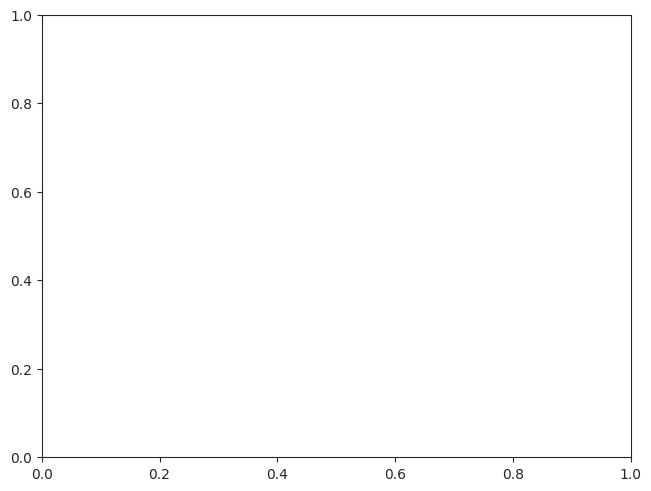

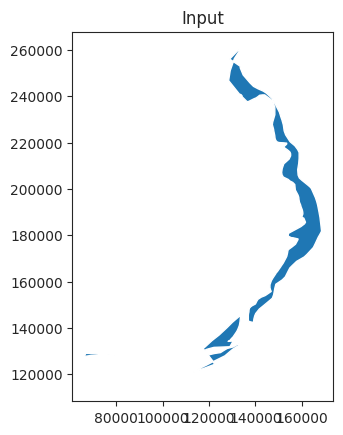

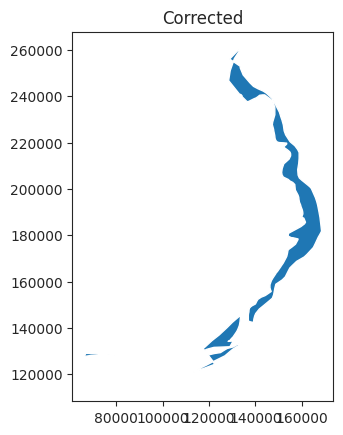

elements_dict must contain at least one dict which contains at least one element


Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/corescpy/corescpy/class_spatial.py", line 315, in crop
    sdata_crop = self.adata.query.polygon(coords, **kws)
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py", line 2232, in polygon
    return polygon_query(  # type: ignore[return-value]
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/functools.py", line 889, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/spatialdata/_core/query/spatial_query.py", line 831, in _
    tables = _get_filtered_or_unfiltered_tables(filter_table, new_elements, sdata)
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/python3.10/site-packages/spatialdata/_core/query/_utils.py", line 99, in _get_filtered_or_unfiltered_tables
    return {
  File "/home/elizabeth/elizabeth/miniconda3/envs/bio/lib/pytho

AttributeError: 'NoneType' object has no attribute 'shapes'

In [6]:
for s in libs:  # iterate samples
    print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    if overwrite is False:  # skip entirely if all crops exist & no overwrite
        all_files = [os.path.join(out_new, "objects_cropped",
                                  r, f'{lib}_{r}.h5ad') for r in regions]
        if overwrite is False and all([os.path.exists(r) for r in all_files]):
            print(f"*** All subsets {', '.join(all_files)} already exist")
            continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # self.update_from_h5ad(file_obj_proc)  # update with processed object
    for coord_suffix in regions:
        print(f"\n\n\t\t{'*' * 40}\n\t\t{s}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        if overwrite is False and os.path.exists(file_obj_crop):
            print(f"*** Subset {file_obj_crop} already exists")
            continue
        if not os.path.exists(file_coord):
            print(f"*** Coordinate file {file_coord} doesn't exist")
            continue
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        # try:
        sdata = self.crop(
            file_coord, allow_make_valid=allow_make_valid)  # crop
        i_x = sdata.table.obs["cell_id"].copy()
        del sdata.table
        sdata.table = adata[adata.obs["cell_id"].isin(i_x[
            i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered
        if plot:
            try:
                sdata.pl.render_labels("cell_labels").pl.show()  # plot
            except Exception:
                pass
        self.adata = sdata
        if write_object is True:
            self.write(file_obj_crop)  # write cropped
        # except Exception:
        #     print(traceback.format_exc(),
        #           f"Cropping \n\n{s}, {coord_suffix} failed!")
print("\n\nCompleted!")

In [14]:
self.adata.table

View of AnnData object with n_obs × n_vars = 5131 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'sample_id', 'subject_id', 'run_id', 'panel_id', 'slide_id', 'clinical_block', 'description', 'date_hybridization', 'date_sectioned', 'location', 'inflammation', 'stricture', 'Condition', 'Age', 'Annotation', 'CDKN1A_PLAUR_threshold2', 'CDKN1A_TP53_PLAUR_threshold2', 'CDKN1A_TP53_threshold2', 'CDKN1A_threshold2', 'Diagnosis', 'Disease_Status', 'Hispanic', 'IL7R_KLRB1_RORC_threshold2', 'IL7R_KLRB1_threshold2', 'IL7R_RORC_threshold2', 'IL7R_threshold2', 'KLRB1_RORC_threshold2', 'KLRB1_threshold2', 'PLAUR_threshold2', 'RORC_threshold2', 'Race', 'Sex', 'TP53_PLAUR_threshold2', 'TP53_threshold2', 'annotation_res0pt5_dist0pt5_npc30', 'annotation_res0pt75_dist0pt3_npc30', 'annotation_res1pt5_dist0_npc30', 'assay_protein', 'b

In [16]:
self.adata.table

AnnData object with n_obs × n_vars = 1038830 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'

In [15]:
sdata_crop = self.adata.query.polygon(coords, **kws)

In [ ]:
sdata_crop

In [9]:
        import os
        import traceback
        import json
        from itertools import permutations
        from warnings import warn
        from copy import deepcopy
        from dask_image.imread import imread
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_pdf import PdfPages
        import shapely
        from shapely.geometry.multipolygon import MultiPolygon
        from shapely.geometry.polygon import Polygon
        import geopandas as gpd
        import squidpy as sq
        import spatialdata
        from spatialdata.models import TableModel
        import spatialdata_plot as sdp
        import spatialdata_io as sdio
        from spatialdata_io._constants._constants import XeniumKeys
        import liana

        bounds_x = file_coord
        bounds_y=None
        bounds_z=None
        pixel_size=0.2125
        allow_make_valid=True
        kwargs={}

        if isinstance(bounds_x, (str, Polygon, MultiPolygon)) or isinstance(
                bounds_x[0], str):  # Xenium Explorer selection(s)
            if isinstance(bounds_x, (list, np.ndarray, tuple, str)):  # file
                if isinstance(bounds_x, (list, np.ndarray, tuple)):  # fileS
                    coords = [cr.pp.xenium_explorer_selection(
                         i, pixel_size=pixel_size, as_list=False)
                               for i in bounds_x]
                else:  # single file
                    coords = cr.pp.xenium_explorer_selection(
                        bounds_x, pixel_size=pixel_size, as_list=False)
            else:  # if shapely object
                coords = bounds_x
            if isinstance(coords, list):  # if multiple selections...
                coords = shapely.MultiPolygon(coords)  # ...union of areas
            kws = {"target_coordinate_system": "global",
                   "filter_table": True, **kwargs}
            if "is_valid" in dir(coords) and coords.is_valid is False:
                if allow_make_valid is True:
                    invalid, error = True, None
                else:
                    p_coords = gpd.GeoSeries(coords).plot()
                    p_coords.set_title("Input")
                    raise ValueError(
                        "Input coordinates have invalid geometry!")

In [13]:
self.adata.table

View of AnnData object with n_obs × n_vars = 5131 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'sample_id', 'subject_id', 'run_id', 'panel_id', 'slide_id', 'clinical_block', 'description', 'date_hybridization', 'date_sectioned', 'location', 'inflammation', 'stricture', 'Condition', 'Age', 'Annotation', 'CDKN1A_PLAUR_threshold2', 'CDKN1A_TP53_PLAUR_threshold2', 'CDKN1A_TP53_threshold2', 'CDKN1A_threshold2', 'Diagnosis', 'Disease_Status', 'Hispanic', 'IL7R_KLRB1_RORC_threshold2', 'IL7R_KLRB1_threshold2', 'IL7R_RORC_threshold2', 'IL7R_threshold2', 'KLRB1_RORC_threshold2', 'KLRB1_threshold2', 'PLAUR_threshold2', 'RORC_threshold2', 'Race', 'Sex', 'TP53_PLAUR_threshold2', 'TP53_threshold2', 'annotation_res0pt5_dist0pt5_npc30', 'annotation_res0pt75_dist0pt3_npc30', 'annotation_res1pt5_dist0_npc30', 'assay_protein', 'b

In [25]:
                    sdata_crop = self.adata.query.polygon(
                        coords, **kws)  # crop

In [28]:
ann = sdata_crop.table.copy()

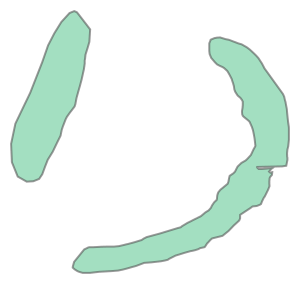

In [31]:
coords

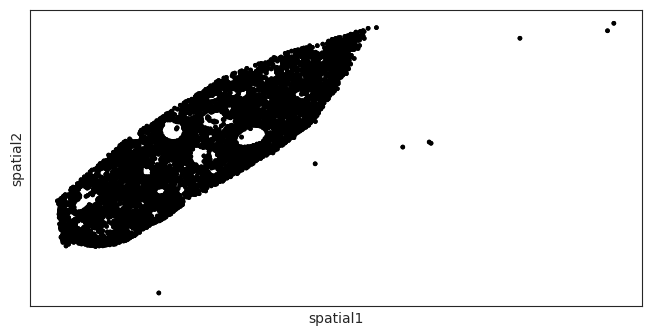

In [30]:
        sq.pl.spatial_scatter(
            sdata_crop.table, library_id="spatial",
            shape=None, color=None, wspace=0.4)

AnnData object with n_obs × n_vars = 5464 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'

In [32]:
        import os
        import traceback
        import json
        from itertools import permutations
        from warnings import warn
        from copy import deepcopy
        from dask_image.imread import imread
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_pdf import PdfPages
        import shapely
        from shapely.geometry.multipolygon import MultiPolygon
        from shapely.geometry.polygon import Polygon
        import geopandas as gpd
        import squidpy as sq
        import spatialdata
        from spatialdata.models import TableModel
        import spatialdata_plot as sdp
        import spatialdata_io as sdio
        from spatialdata_io._constants._constants import XeniumKeys
        import liana


        bounds_y=None
        bounds_z=None
        pixel_size=0.2125
        allow_make_valid=True
        kwargs={}
        coord_suffix = "smc_longitudinal"

        print(f"\n\n\t\t{'*' * 40}\n\t\t{s}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")

        bounds_x = file_coord

        if isinstance(bounds_x, (str, Polygon, MultiPolygon)) or isinstance(
                bounds_x[0], str):  # Xenium Explorer selection(s)
            if isinstance(bounds_x, (list, np.ndarray, tuple, str)):  # file
                if isinstance(bounds_x, (list, np.ndarray, tuple)):  # fileS
                    coords = [cr.pp.xenium_explorer_selection(
                         i, pixel_size=pixel_size, as_list=False)
                               for i in bounds_x]
                else:  # single file
                    coords = cr.pp.xenium_explorer_selection(
                        bounds_x, pixel_size=pixel_size, as_list=False)
            else:  # if shapely object
                coords = bounds_x
            if isinstance(coords, list):  # if multiple selections...
                coords = shapely.MultiPolygon(coords)  # ...union of areas
            kws = {"target_coordinate_system": "global",
                   "filter_table": True, **kwargs}
        #     if "is_valid" in dir(coords) and coords.is_valid is False:
        #         if allow_make_valid is True:
        #             invalid, error = True, None
        #         else:
        #             p_coords = gpd.GeoSeries(coords).plot()
        #             p_coords.set_title("Input")
        #             raise ValueError(
        #                 "Input coordinates have invalid geometry!")
        #     else:
        #         invalid = False
        #         try:
        #             sdata_crop = self.adata.query.polygon(
        #                 coords, **kws)  # crop
        #         except Exception as err:
        #             sdata_crop = None
        #             if allow_make_valid is False:
        #                 raise err
        #             invalid, error = True, err
        #     if invalid is True:
        #         if allow_make_valid is True:
        #             try:
        #                 warn("\n\n*** Invalid geometry! Making geometry valid"
        #                      ". Check new coordinates!\n\n")
        #                 p_coords = gpd.GeoSeries(coords).plot()
        #                 p_coords.set_title("Input")
        #                 plt.show()
        #                 coords = shapely.validation.make_valid(coords)
        #                 p_coords_new = gpd.GeoSeries(coords).plot()
        #                 p_coords_new.set_title("Corrected")
        #                 plt.show()
        #                 sdata_crop = self.adata.query.polygon(coords, **kws)
        #             except Exception:
        #                 sdata_crop = None
        #                 print(error)
        #                 traceback.print_exc()
        #     if "table" not in dir(sdata_crop):
        #         sdata_crop.table = self.rna[self.rna.obs[
        #             XeniumKeys.CELL_ID].isin(sdata_crop.shapes[
        #                 "cell_boundaries"].index)].copy()  # add back table
        #         # needed for now b/c issue if any nuclei radius = NA
        #         # github.com/scverse/spatialdata-io/
        #         # issues/173#issuecomment-2231152498
        #     else:
        #         i_x = sdata_crop.table.obs["cell_id"].copy()
        #         del sdata_crop.table
        #         sdata_crop.table = self.rna[self.rna.obs["cell_id"].isin(i_x[
        #             i_x.isin(self.rna.obs["cell_id"])])]
        # else:  # specified coordinates
        #     minc, maxc = [[x[i] for x in [bounds_x, bounds_y, bounds_z] if (
        #         x is not None)] for i in [0, 1]]
        #     kws_def = dict(axes=("x", "y", "z") if bounds_z else ("x", "y"),
        #                    target_coordinate_system="global")
        #     sdata_crop = spatialdata.bounding_box_query(
        #         self.adata, min_coordinate=minc,
        #         max_coordinate=maxc, **{**kws_def, **kwargs})



		****************************************
		50217A
		****************************************




Data: /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__20240415__212906
Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A.h5ad
Coordinates: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/smc_longitudinal/50217A_smc_longitudinal.csv
Ouput: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Inflamed-50217A_smc_longitudinal.h5ad


In [ ]:
ls

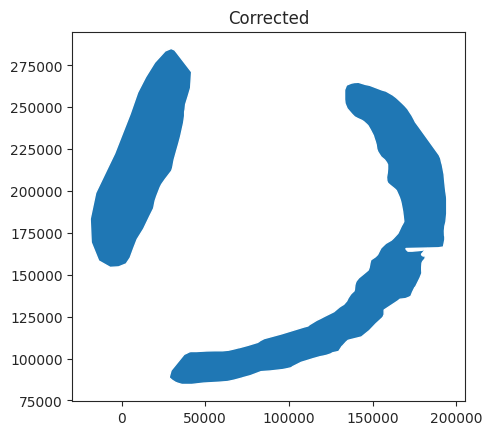

<Axes: >

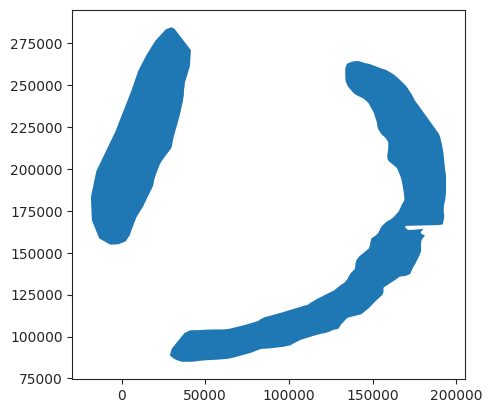

In [23]:
coords = shapely.validation.make_valid(coords)
p_coords_new = gpd.GeoSeries(coords).plot()
p_coords_new.set_title("Corrected")
plt.show()
gpd.GeoSeries(coords).plot()

# Example Setting Regions by Exclusion

In [ ]:
s_o = "50217A"
out_new = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              "outputs/TUQ97N/nebraska")
# mid = pd.read_csv(os.path.join(out_new, f"coordinates/{s_o}_mid.csv"),
#                   index_col=0).iloc[:, 0]
# mid = gpd.GeoDataFrame(mid, geometry=gpd.GeoSeries.from_wkt(
#     mid), crs="EPSG:4326")
# mid = mid.geometry.apply(lambda geom: shapely.Polygon(geom)).iloc[0]
mye, ser, muc, icm = [cr.pp.xenium_explorer_selection(os.path.join(
    out_new, "coordinates", r, f"{s_o}_{r}.csv"))
            for r in ["myenteric_plexus", "serosa", "mucosa", "smc_circular"]]
mye, ser, muc, icm = [x if x.is_valid else shapely.validation.make_valid(
    x) for x in [mye, ser, muc, icm]]
# muc = cr.pp.xenium_explorer_selection(os.path.join(
#     out_new, "coordinates", "mucosa", f"{s_o}_mucosa_full.csv"))
# muc = shapely.validation.make_valid(muc)
# other = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_other.csv")))
# smc = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_smc.csv")))
# whole = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_all.csv")))
# olm = cr.pp.xenium_explorer_selection(os.path.join(
#     out_new, "coordinates", "smc_longitudinal",
#     f"{s_o}_smc_longitudinal.csv"))
other, olm, smc, whole = None, None, None, None

In [ ]:
for r in zip(["whole", "mye", "ser", "muc", "smc", "icm", "olm"], [
        whole, mye, ser, muc, smc, icm, olm]):
    if r[1] is None:
        continue
    p_coords = gpd.GeoSeries(r[1]).plot()
    p_coords.set_title(r[0])
    plt.show()

In [ ]:
olm = smc.difference(mye).difference(icm).difference(ser)
olm

In [ ]:

muc

In [ ]:
sub = whole.difference(muc).difference(icm).difference(olm).difference(
    mye).difference(ser).difference(smc)
sub

In [ ]:
data = {}
for i, p in enumerate(olm.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i}"] += [{"X": xi, "Y": yi}]
    data[f"Selection {i}"] = pd.DataFrame(data[f"Selection {i}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "smc_longitudinal",
#     "50217A_smc_longitudinal.csv") + " " + os.path.join(
#         out_new, "coordinates", "smc_longitudinal",
#         "50217A_smc_longitudinal_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "smc_longitudinal",
#                          "50217A_smc_longitudinal.csv"))

data = {}
for i, p in enumerate(muc.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i}"] += [{"X": xi, "Y": yi}]
    data[f"Selection {i}"] = pd.DataFrame(data[f"Selection {i}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "mucosa",
#     "50217A_mucosa.csv") + " " + os.path.join(
#         out_new, "coordinates", "mucosa", "50217A_mucosa_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "mucosa",
#                          "50217A_mucosa.csv"))

data = {}
for i, p in enumerate(icm.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i}"] += [{"X": xi, "Y": yi}]
    data[f"Selection {i}"] = pd.DataFrame(data[f"Selection {i}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "smc_circular",
#     "50217A_smc_circular.csv") + " " + os.path.join(
#         out_new, "coordinates", "smc_circular",
#         "50217A_smc_circular_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "smc_circular",
#                          "50217A_smc_circular.csv"))

data = {}
for i, p in enumerate(sub.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i}"] += [{"X": xi, "Y": yi}]
    data[f"Selection {i}"] = pd.DataFrame(data[f"Selection {i}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "submucosa",
#     "50217A_submucosa.csv") + " " + os.path.join(
#         out_new, "coordinates", "submucosa",
#         "50217A_submucosa_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "submucosa",
#                          "50217A_submucosa.csv"))

In [ ]:
for r in zip(["whole", "mye", "ser", "muc", "smc", "icm", "olm"], [
        whole, mye, ser, muc, smc, icm, olm]):
    if r[1] is None:
        continue
    p_coords = gpd.GeoSeries(r[1]).plot()
    p_coords.set_title(r[0])
    plt.show()

# Workspace

In [ ]:
self.adata.shapes["cell_circles"]["radius"].isna().sum()

In [ ]:
self.rna[self.rna.obs["cell_id"].isin(sdata.shapes["cell_boundaries"].index)]

In [ ]:
self.adata.get_annotated_regions(self.adata.table)

In [ ]:
from spatialdata_io._constants._constants import XeniumKeys

transform = Scale([1.0 / 0.2125, 1.0 / 0.2125], axes=("x", "y"))
radii = np.sqrt(self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA].to_numpy() / np.pi)

In [ ]:
self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA]

In [ ]:
[i[1] for i in self.adata._gen_elements()]

In [ ]:
found_regions = set(table.obs["cell_id"].unique().tolist())
target_element_set = ["cell_boundaries"]
symmetric_difference = found_regions.symmetric_difference(target_element_set)
len(symmetric_difference)

In [ ]:
self.adata._change_table_annotation_target(self.adata.table, "cell_labels")

In [ ]:
table.uns.get("spatialdata_attrs")

In [ ]:
self.adata.set_table_annotates_spatialelement("table", region="cell_labels")

In [ ]:
# element = self.adata.shapes["cell_circles"]
# buffered_df = element.copy()
# buffered = to_polygons(element)

In [ ]:
# coord_suffix = "myenteric_plexus"
# coord_suffix = "smc_circular"
coord_suffix = "smc_longitudinal"
# s = "50006B"
# s =  "50217A"
# s = "50217B"

# for s in ["50006A", "50217A", "50403B"]:
for s in ["50006A"]:
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    dir_coord = os.path.join(
        out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
    out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
    os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
    file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
    file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
    if os.path.exists(file_obj_crop):
        continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # coords = cr.pp.xenium_explorer_selection(file_coord, pixel_size=0.2125)
    # if isinstance(coords, list):  # if multiple selections...
    #     coords = shapely.MultiPolygon(coords)  # ...union of areas
    # kws = {"target_coordinate_system": "global", "filter_table": True}
    # try:
    #     sdata = self.adata.query.polygon(coords, **kws)  # crop
    # except Exception as err:
    #     if allow_make_valid:
    #         warn("\n\n*** Invalid geometry! Making geometry valid."
    #              "Check new coordinates!\n\n")
    #         coords_new = shapely.validation.make_valid(coords)
    #         sdata = self.adata.query.polygon(coords_new, **kws)  # crop
    #     else:
    #         raise err
    # i_x = sdata.table.obs["cell_id"].copy()
    # del sdata.table
    # sdata.table = adata[adata.obs["cell_id"].isin(i_x[
    #     i_x.isin(adata.obs["cell_id"])])]
    sdata = self.crop(file_coord, allow_make_valid=allow_make_valid)
    if not os.path.exists(file_obj_crop):
        sdata.tables["table"].write_h5ad(os.path.join(
            out, f"{self._library_id}_{coord_suffix}.h5ad"))

In [ ]:
import geopandas as gpd
import shapely

#Create a test dataframe
    #The first line is valid, the second is not, it starts and ends at the same point
wkts  = ["LINESTRING (30 10, 10 30, 40 40)", "LINESTRING (30 10, 30 10)"]
geometries = [shapely.wkt.loads(x) for x in wkts] #Create shapely geometries
df = gpd.GeoDataFrame(geometry=geometries) #And a data frame

invalid = df.loc[~df.geometry.is_valid]

In [ ]:
from shapely.validation import make_valid

In [ ]:
import squidpy as sq

sq.pl.spatial_scatter(sdata_crop.table)

In [ ]:
sdata.pl.render_labels("cell_labels").pl.show()  # plot

In [ ]:
elements = self.gen_spatial_elements()

In [ ]:
cr.pp.xenium_explorer_selection(file_coord)